In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['science','ieee'])
from scipy import stats
import numpy as np
from matplotlib import rc
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
rc('font',**{'family':'sans-serif','sans-serif':['Palatino']})
from matplotlib import rcParams

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

from scipy.constants import golden_ratio, inch
import sys, os
import numpy as np
from scipy.optimize import curve_fit, leastsq
from copy import deepcopy
import pickle

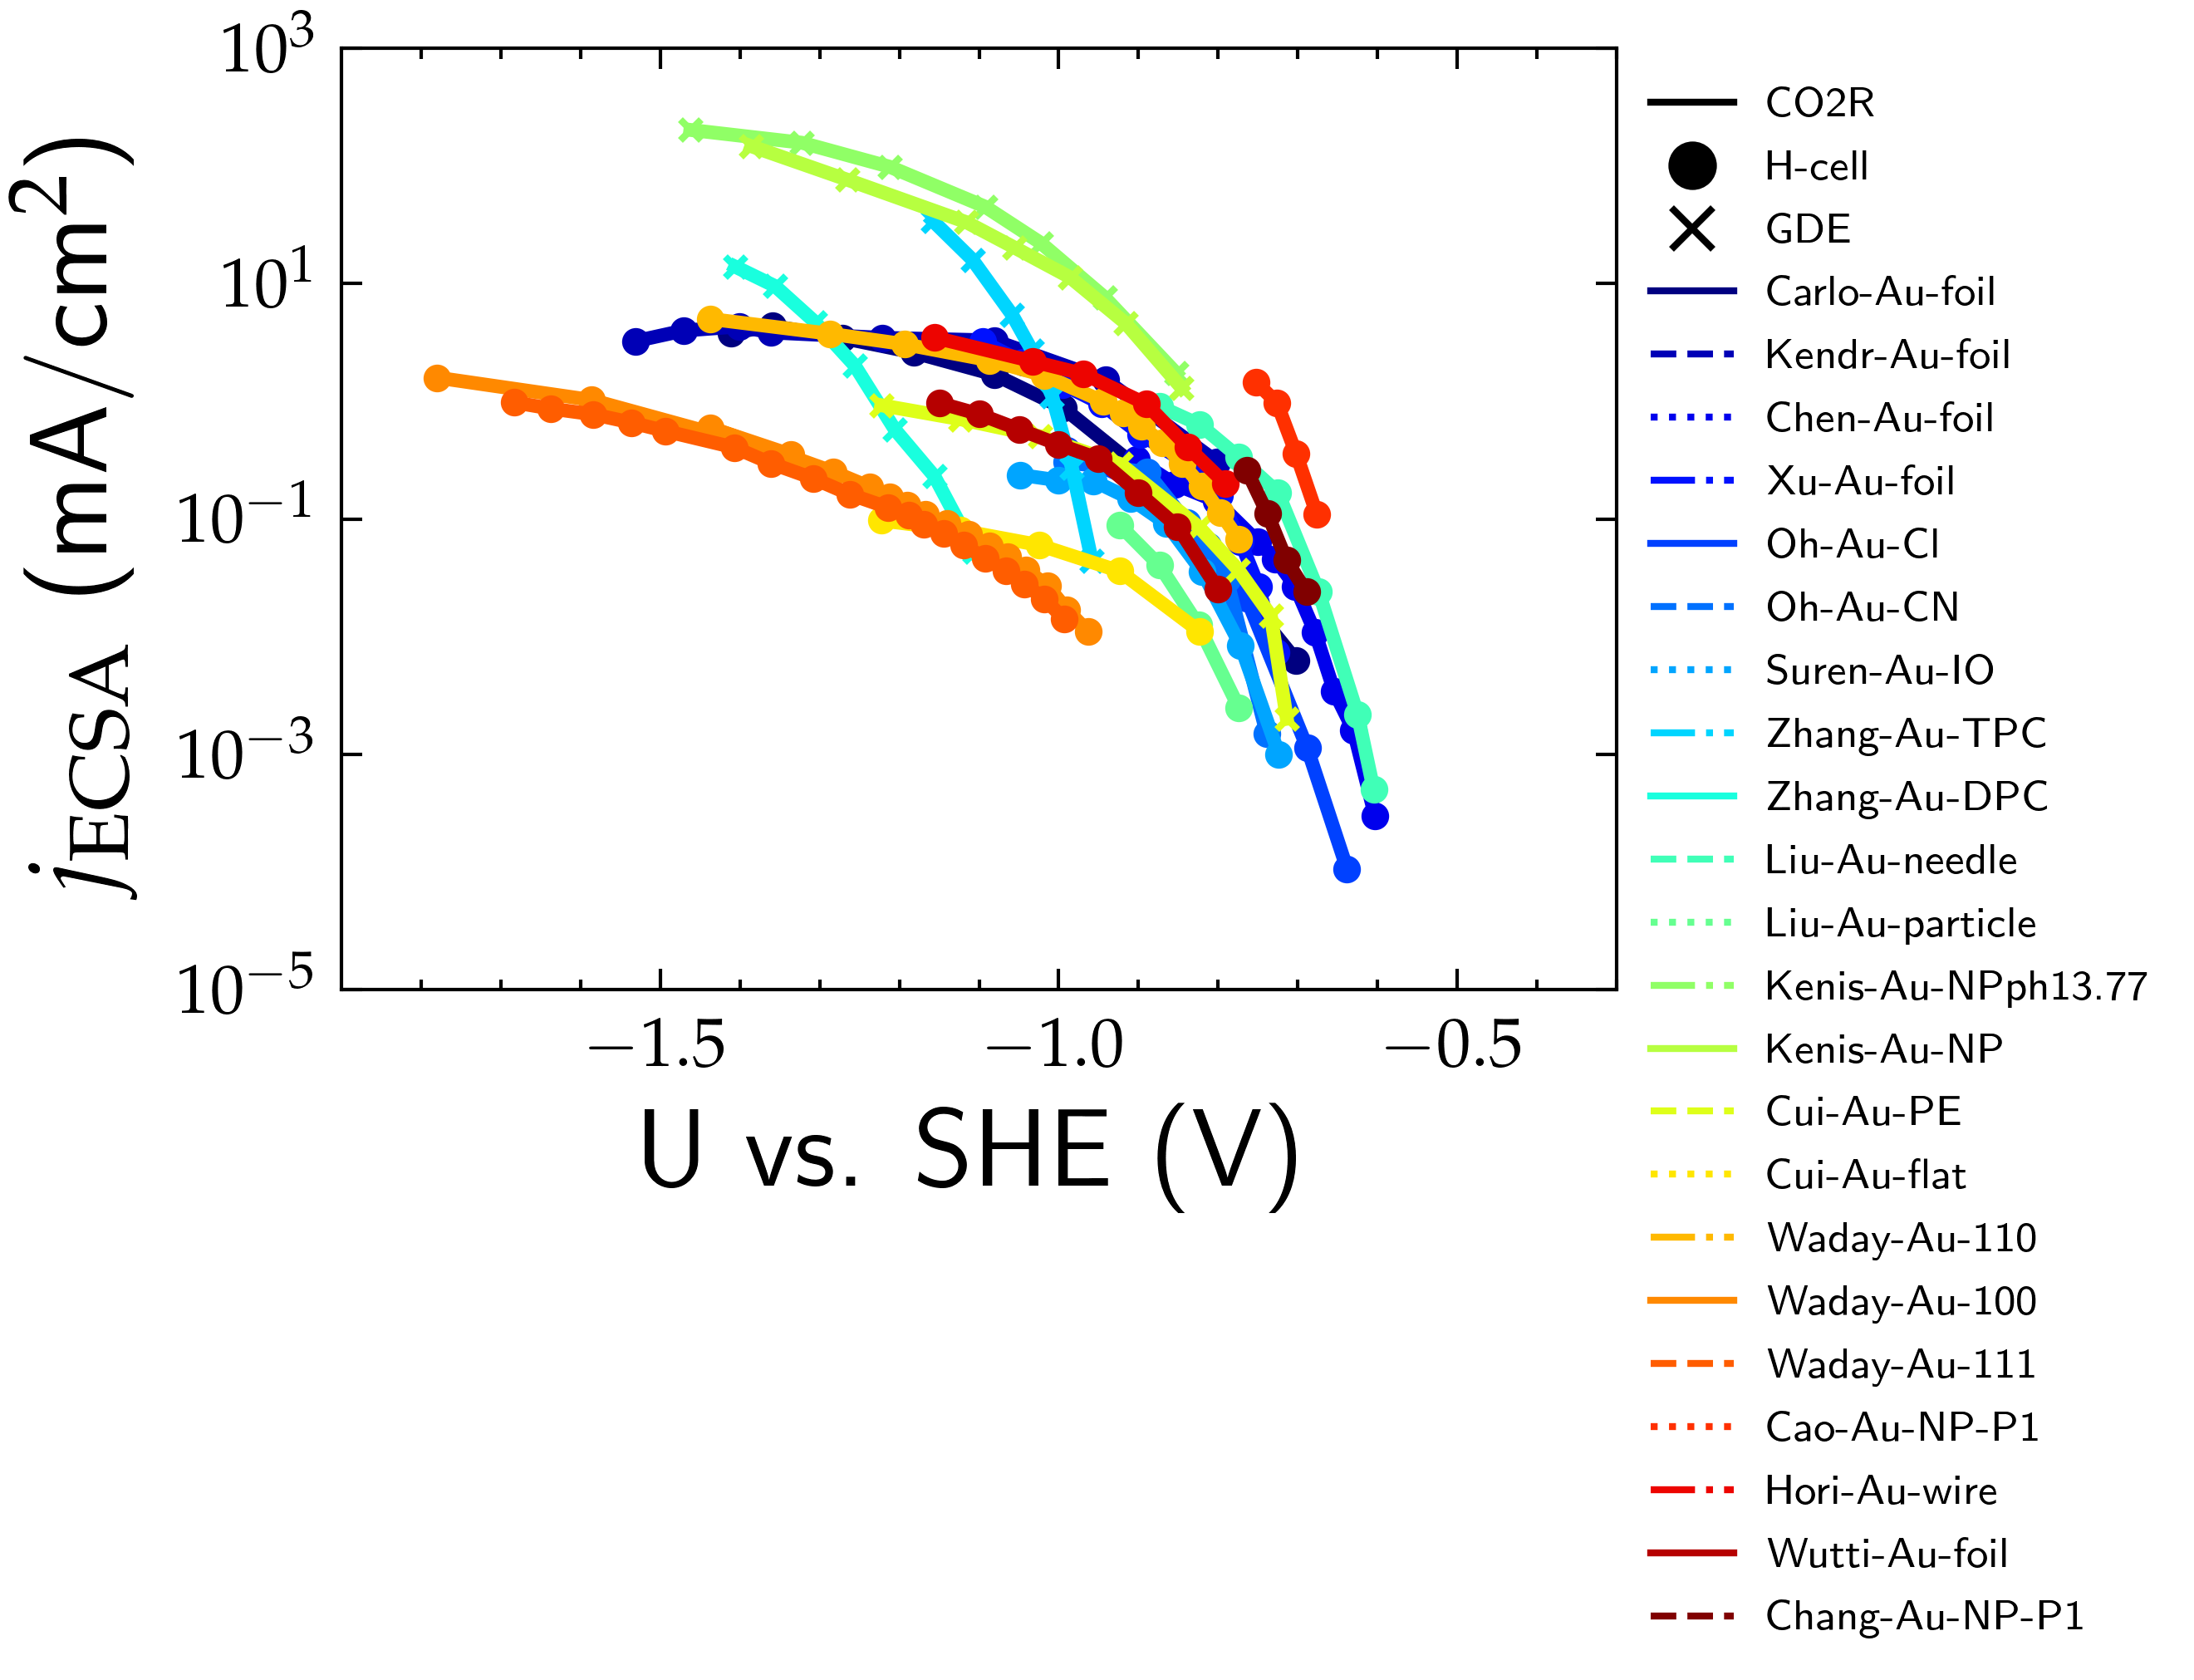

In [11]:
def _compute_partial_jecsa(data, adsorbate, maxpH=100.):
    data = deepcopy(data)
    out = {}
    for k in data:
        if data[k]['roughness'] != 'None' and adsorbate in data[k]:
            # transform total current into j-ecsa
            j_ecsa = data[k]['I(mA/cm2)'] / float(data[k]['roughness'])
            # multiply with FE for chosen product
            pj = np.array([data[k][adsorbate][i,:]*j_ecsa[i] for i in range(len(j_ecsa))])
            ind = np.where(pj != 0.0)[0]
            pj = np.absolute(pj[ind,:]) # correct for current definition
            urhe = data[k]['V_RHE'][ind,:]
            ushe = deepcopy(urhe)
            ushe[:,0] -= 0.059 * float(data[k]['pH'])
            if float(data[k]['pH']) <= maxpH:
                out.update({k:{'U_RHE':urhe, 'U_SHE':ushe, 'j_partial':pj, 'cell':data[k]['cell'], 'mode':data[k]['mode'], 'pH':data[k]['pH']}})
        else:
            print("%s does not contain roughness or %s"%(k, adsorbate))
    return(out)

def plot_partial_current_densities(filename, data, adsorbate, pot, clr='data'):
    if clr == 'data':
        ks = list(data.keys())
    elif clr == 'pH':
        ks = (np.unique([float(data[k]['pH']) for k in data])).tolist()
    colors = plt.cm.jet(np.linspace(0,1,len(ks)))
    kclr = {ks[i]:colors[i] for i in range(len(ks))}
    lss = {'CO2R':'-'}
    mks = {'H-cell':'o', 'GDE':'x'}

    for k in data:
        x1 = data[k][pot][:,0]; xerr1 = data[k][pot][:,1]

        if np.all(xerr1 == 0.0):
            xerr1 = None

        kc = k
        if clr == 'pH':
            kc = float(data[k]['pH'])
        
        y = data[k]['j_partial'][:,0]; yerr = data[k]['j_partial'][:,1]
        if np.all(yerr == 0.0):
            yerr = None
        #if data[k]['cell'] == 'GDE' and data[k]['mode'] == 'COR':
        if True:
            plt.errorbar(x1, y, xerr=xerr1, yerr=yerr,ls=lss[data[k]['mode']],marker=mks[data[k]['cell']], color=kclr[kc], markersize=3,lw=2)

    # legend
    for l in lss:
        plt.plot(np.nan, np.nan, color='k', ls=lss[l], label=r'%s'%l)
    for m in mks:
        plt.plot(np.nan, np.nan, color='k', ls='None', marker=mks[m], label=r'%s'%m)
    for k in ks:
        plt.plot(np.nan, np.nan, color=kclr[k], label=r'%s'%k)
    plt.legend(loc=1,prop={'size':6},bbox_to_anchor=(1.45, 1.))

    plt.xlim(-1.9,-0.3)
    plt.ylim(1e-5,1000)

    plt.yscale('log')
    plt.xlabel('U vs. %s (V)'%pot.split('_')[1])

    plt.ylabel('$j_{\mathrm{ECSA}}$ (mA/cm$^2$)')

    plt.savefig('CO-ECSA.eps')


def _load_pickle_file(filename,py23=False):
    pickle_file = open(filename,'rb')
    if py23:
        data = pickle.load(pickle_file, encoding='latin1')
    else:
        data = pickle.load(pickle_file)
    pickle_file.close()
    return(data)

def load_pkl_data(folders,data=None):
    if data is None:
        data={}
    # collect all data
    for f in folders:
        pklfile = "%s/%s.pkl"%(f,f)
        if pklfile.split('/')[-1] not in os.listdir(f):
            print('\033[92mCouldnt find input pkl in %s, creating it\033[0m'%f)
            create_input_pkl(f)

        dat = _load_pickle_file(pklfile)

        tag = f.split('_')[0][:5]
        for k in dat:
            if k != 'Cu_oh': # faulty potential
                data.update({tag+'-'+k:dat[k]})
    return data

if __name__ == "__main__":
    #Note: Zhang_CO2R, Kenis_CO2R do not report roughness/ECSA
    folders = ["Carlos_CO2R","Kendra_CO2R","Chen_CO2R","Xu_CO2R","Oh_CO2R",
              "Surendranath_CO2R","Zhang_CO2R","Liu_CO2R","Kenis_CO2R","Cui_CO2R",
              "Wadayama_CO2R","Cao_CO2R","Hori_CO2R","Wuttig_CO2R","Chang_CO2R"]


    # collect all data
    data = load_pkl_data(folders)
    maxpH=100
    for ads in ['CO']:
        a_dat = _compute_partial_jecsa(data, adsorbate=ads, maxpH=maxpH)
        plot_partial_current_densities('partial_j_%s_maxpH%.0f'%(ads,maxpH), a_dat, ads, pot='U_SHE')
    